In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *

In [2]:
NUM_SAMPLES_PER_CLASS = 1_000
NUM_VAL = 50 * 340

In [3]:
PATH = Path('data/txt')

### Generate data from csvs

In [4]:
PATH.mkdir(exist_ok=True)
(PATH/'train').mkdir(exist_ok=True)
(PATH/'test').mkdir(exist_ok=True)

In [5]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (PATH/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(PATH/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(PATH/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [6]:
%time create_test_txts_from_df('data/test_simplified.csv')

CPU times: user 29.2 s, sys: 2.38 s, total: 31.6 s
Wall time: 31.7 s


In [7]:
%time for p in Path('data/train').iterdir(): create_train_txts_from_df(p)

CPU times: user 5min 29s, sys: 18.6 s, total: 5min 48s
Wall time: 5min 44s


###  Create ImageDataBunch using the data block API

In [8]:
sz = 128
bs = 640

In [9]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [10]:
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)

In [11]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]

In [12]:
item_lists = item_list.split_by_idx(val_idxs)

In [13]:
# label_lists = item_lists.label_from_folder()
# pd.to_pickle(label_lists.train.y.classes, 'data/classes.pkl')

In [14]:
classes = pd.read_pickle('data/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);

In [15]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=12)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=12)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [16]:
# pd.to_pickle(data_bunch.batch_stats(), f'data/batch_stats_{sz}.pkl')

In [17]:
batch_stats = pd.read_pickle(f'data/batch_stats_{sz}.pkl')

In [18]:
data_bunch.normalize(batch_stats);

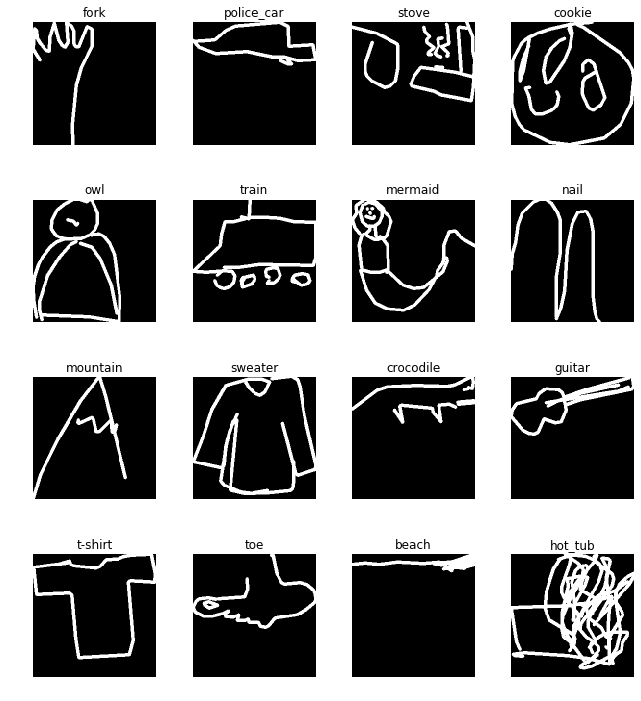

In [19]:
data_bunch.show_batch(rows=4)

### Train

In [20]:
name = f'res34-{sz}'

In [21]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [22]:
learn.fit_one_cycle(2)

Total time: 06:00
epoch  train_loss  valid_loss  accuracy  map3    
1      1.937478    1.607339    0.608647  0.695402  (03:01)
2      1.658560    1.443055    0.652294  0.731284  (02:59)



In [23]:
learn.save(f'{name}-stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 24:25
epoch  train_loss  valid_loss  accuracy  map3    
1      1.448672    1.383536    0.658706  0.739206  (04:04)
2      1.358841    1.285606    0.681059  0.757471  (04:04)
3      1.165717    1.180751    0.707647  0.780500  (04:04)
4      0.927250    1.081052    0.732294  0.800314  (04:03)
5      0.639683    1.044819    0.744294  0.810804  (04:03)
6      0.454999    1.067124    0.744647  0.810461  (04:03)



In [26]:
learn.save(f'{name}-stage-2')

### Predict

In [27]:
learn.load(f'{name}-stage-2');

In [28]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
create_submission(preds, data_bunch.test_dl, name, classes)

In [32]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9221337500464606,sock shoe foot
1,9950013608613660,leaf feather stitches
2,9005540600650567,broom paintbrush rake
3,9031090525591545,chair giraffe toilet
4,9896706467105420,flamingo swan bird


In [33]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.52M/1.52M [00:17<00:00, 93.0kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge